In [31]:
import pandas as pd
import folium
import psycopg2
from dotenv import load_dotenv
import folium
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from prophet import Prophet

In [15]:
load_dotenv('credentials.env')

# Print out the environment variables to confirm they're loaded
print("DB_HOST:", os.getenv("DB_HOST"))
print("DB_NAME:", os.getenv("DB_NAME"))
print("DB_USER:", os.getenv("DB_USER"))
print("DB_PASSWORD:", os.getenv("DB_PASSWORD"))
print("DB_PORT:", os.getenv("DB_PORT"))



DB_HOST: pinot.cs.ucsb.edu
DB_NAME: pinot
DB_USER: cs190nf24g10
DB_PASSWORD: YKUkr3GV
DB_PORT: 5432


In [16]:
try:
    conn = psycopg2.connect(
        host=os.getenv("DB_HOST"),
        database=os.getenv("DB_NAME"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        port=os.getenv("DB_PORT")
    )
    print("Connected successfully.")
    cur = conn.cursor()
    query = "SELECT time, signal, packet_loss FROM public.wifistats LIMIT 100;"
    cur.execute(query)
    data = cur.fetchall()

    wifi_df = pd.DataFrame(data, columns=['time', 'signal (dBm)', 'packet_loss'])
    wifi_df['time'] = pd.to_datetime(wifi_df['time'])
except Exception as e:
    print("Failed to connect to the database.")
    print("Error:", e)

Connected successfully.


In [17]:
try:
    if conn is not None:
        cur = conn.cursor()
        query = "SELECT label, time, signal, packet_loss FROM public.wifistats LIMIT 100;"
        cur.execute(query)
        data = cur.fetchall()
        for row in data:
            print(row)
        cur.close()
    else:
        print("Connection was not established.")
except Exception as e:
    print("Error executing the query.")
    print("Error:", e)

('raspi-e4:5f:01:ac:ed:5b', datetime.datetime(2024, 6, 24, 2, 39, 40, 280950), -66.0, 0.0)
('raspi-e4:5f:01:8d:ca:34', datetime.datetime(2024, 6, 24, 2, 39, 40, 281437), -65.0, 0.0)
('raspi-e4:5f:01:9c:20:81', datetime.datetime(2024, 6, 24, 2, 39, 40, 281833), -66.0, 0.0)
('raspi-e4:5f:01:8d:07:fe', datetime.datetime(2024, 6, 24, 2, 39, 40, 282211), -75.0, 0.0)
('raspi-e4:5f:01:8c:8a:41', datetime.datetime(2024, 6, 24, 2, 49, 55, 886456), -51.0, 0.0)
('raspi-e4:5f:01:56:d8:f3', datetime.datetime(2024, 6, 24, 2, 49, 55, 888764), -69.0, 0.0)
('raspi-e4:5f:01:9c:24:87', datetime.datetime(2024, 6, 24, 2, 49, 55, 889293), -53.0, 0.0)
('raspi-e4:5f:01:72:a4:93', datetime.datetime(2024, 6, 24, 2, 49, 55, 889729), -55.0, 0.0)
('raspi-e4:5f:01:6c:98:83', datetime.datetime(2024, 6, 24, 2, 49, 55, 890146), -46.0, 0.0)
('raspi-e4:5f:01:8b:bc:d9', datetime.datetime(2024, 6, 24, 2, 49, 55, 890686), -58.0, 0.0)
('raspi-e4:5f:01:a0:4a:dd', datetime.datetime(2024, 6, 24, 2, 49, 55, 891140), -40.0, 0.0)

       signal (dBm)  packet_loss
count     100.00000        100.0
mean      -57.26000          0.2
std         8.25921          2.0
min       -75.00000          0.0
25%       -65.00000          0.0
50%       -57.50000          0.0
75%       -51.75000          0.0
max       -38.00000         20.0


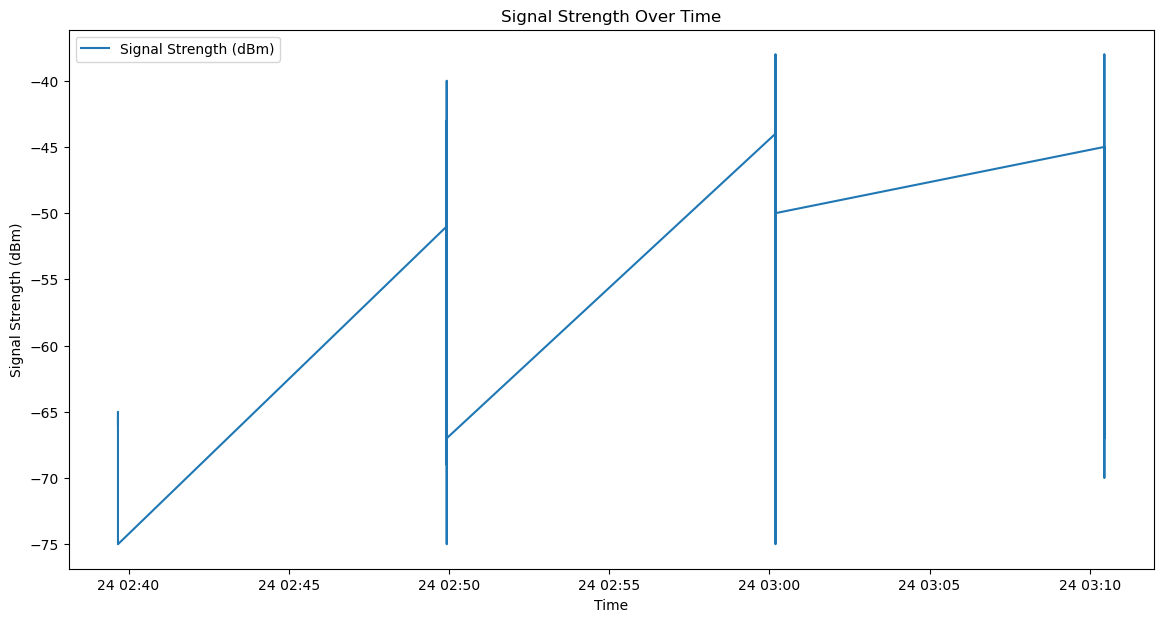

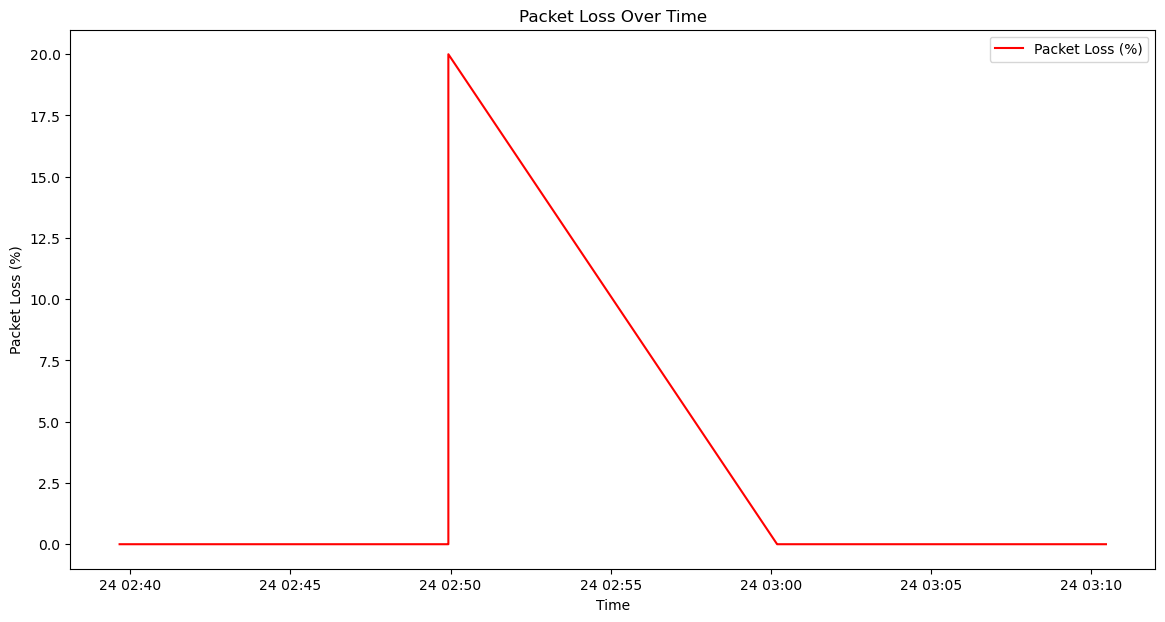

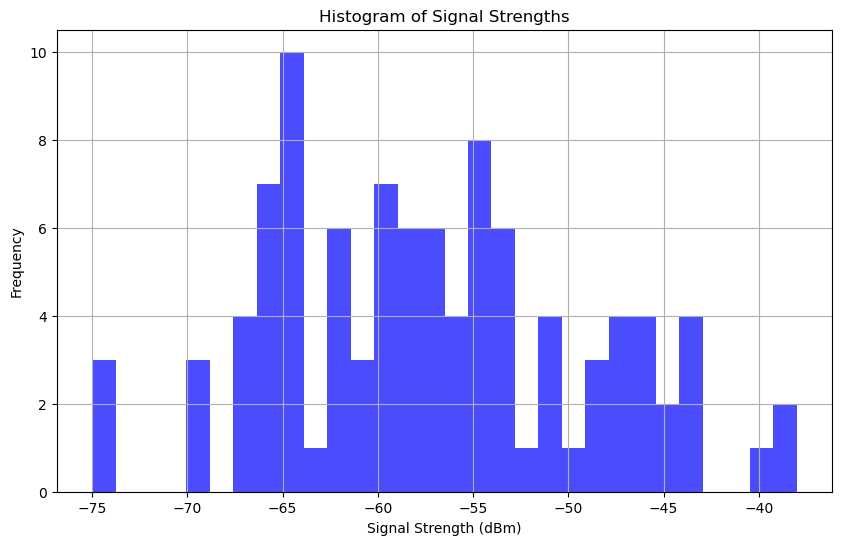

Correlation Matrix:
               signal (dBm)  packet_loss
signal (dBm)       1.00000     -0.11912
packet_loss       -0.11912      1.00000


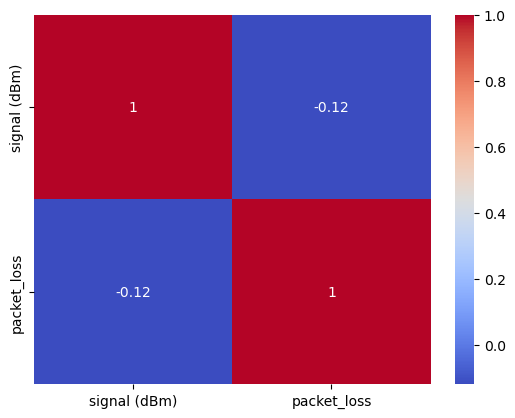

In [18]:
print(wifi_df.describe())

plt.figure(figsize=(14, 7))
plt.plot(wifi_df['time'], wifi_df['signal (dBm)'], label='Signal Strength (dBm)')
plt.title('Signal Strength Over Time')
plt.xlabel('Time')
plt.ylabel('Signal Strength (dBm)')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(wifi_df['time'], wifi_df['packet_loss'], label='Packet Loss (%)', color='red')
plt.title('Packet Loss Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Loss (%)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(wifi_df['signal (dBm)'], bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Signal Strengths')
plt.xlabel('Signal Strength (dBm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

correlation = wifi_df[['signal (dBm)', 'packet_loss']].corr()
print("Correlation Matrix:\n", correlation)

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [19]:
cur = conn.cursor()
query = "SELECT time, signal, packet_loss FROM public.wifistats LIMIT 100;"
cur.execute(query)
data = cur.fetchall()
wifi_df = pd.DataFrame(data, columns=['time', 'signal (dBm)', 'packet_loss'])
wifi_df['time'] = pd.to_datetime(wifi_df['time'])
fig_signal = px.line(wifi_df, x='time', y='signal (dBm)', title='Signal Strength Over Time', labels={'signal (dBm)': 'Signal Strength (dBm)'})
fig_signal.update_xaxes(rangeslider_visible=True)
fig_signal.show()
fig_loss = px.line(wifi_df, x='time', y='packet_loss', title='Packet Loss Over Time', labels={'packet_loss': 'Packet Loss (%)'})
fig_loss.update_xaxes(rangeslider_visible=True)
fig_loss.show()

In [20]:
try:
    cur = conn.cursor()
    query = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'wifistats';
    """
    cur.execute(query)
    columns = cur.fetchall()
    column_names = [col[0] for col in columns]
    print("Column Titles in 'wifistats':")
    for col in column_names:
        print(col)
except Exception as e:
    print("Error fetching column titles.")
    print("Error:", e)

Column Titles in 'wifistats':
signal
time
packet_loss
rx_bitrate
connected_time
tx_bitrate
ping
label


In [21]:
def print_column_titles(table_name):
    try:
        cur = conn.cursor()
        query = f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_name = '{table_name}';
        """
        cur.execute(query)
        columns = cur.fetchall()

        if columns:
            print(f"Column Titles in '{table_name}':")
            for col in columns:
                print(col[0])
        else:
            print(f"No columns found for table '{table_name}'.")
    except Exception as e:
        print(f"Error fetching column titles for table '{table_name}'.")
        print("Error:", e)
tables = ["wifistats", "devices", "extra_info"]
for table in tables:
    print_column_titles(table)
    print() 

Column Titles in 'wifistats':
signal
time
packet_loss
rx_bitrate
connected_time
tx_bitrate
ping
label

Column Titles in 'devices':
wireless_bytes
wired_bytes
last_seen
location
tags
label
uptime
comment
ethernet_mac
wlan_mac

Column Titles in 'extra_info':
latitude
longtitude
label
comment
contact_person



In [26]:
try:
    cur = conn.cursor()
    telemetry_query = """
    SELECT label, time, signal, rx_bitrate, tx_bitrate, packet_loss
    FROM public.wifistats
    LIMIT 1000; -- Adjust limit as needed for testing or full analysis
    """
    cur.execute(telemetry_query)
    telemetry_data = cur.fetchall()
    telemetry_df = pd.DataFrame(telemetry_data, columns=['label', 'time', 'signal', 'rx_bitrate', 'tx_bitrate', 'packet_loss'])
    location_query = """
    SELECT label, latitude, longtitude
    FROM public.extra_info
    WHERE latitude IS NOT NULL AND longtitude IS NOT NULL;
    """
    cur.execute(location_query)
    location_data = cur.fetchall()
    location_df = pd.DataFrame(location_data, columns=['label', 'latitude', 'longitude'])

except Exception as e:
    print("Error fetching data.")
    print("Error:", e)
telemetry_df['time'] = pd.to_datetime(telemetry_df['time'])
telemetry_df = telemetry_df.merge(location_df, on='label', how='inner')
telemetry_df['signal'] = telemetry_df['signal'].replace('None', np.nan).astype(float)
telemetry_df['rx_bitrate'] = (
    telemetry_df['rx_bitrate']
    .replace('None', np.nan)
    .str.extract(r'([\d\.]+)')  
    .astype(float)
)
telemetry_df['tx_bitrate'] = (
    telemetry_df['tx_bitrate']
    .replace('None', np.nan)
    .str.extract(r'([\d\.]+)') 
    .astype(float)
)
telemetry_df['packet_loss'] = telemetry_df['packet_loss'].replace('None', np.nan).astype(float)
heatmap = folium.Map(location=[34.4140, -119.8489], zoom_start=14) 

for _, row in telemetry_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if row['signal'] > -60 else 'red', 
        fill=True,
        fill_opacity=0.7,
        popup=f"""
        Device: {row['label']}<br>
        Signal: {row['signal']} dBm<br>
        RX Bitrate: {row['rx_bitrate']} MBit/s<br>
        TX Bitrate: {row['tx_bitrate']} MBit/s<br>
        Packet Loss: {row['packet_loss']}%
        """
    ).add_to(heatmap)
heatmap.save("network_performance_heatmap.html")
print("Heatmap saved as 'network_performance_heatmap.html'.")

Heatmap saved as 'network_performance_heatmap.html'.


15:44:48 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] done processing


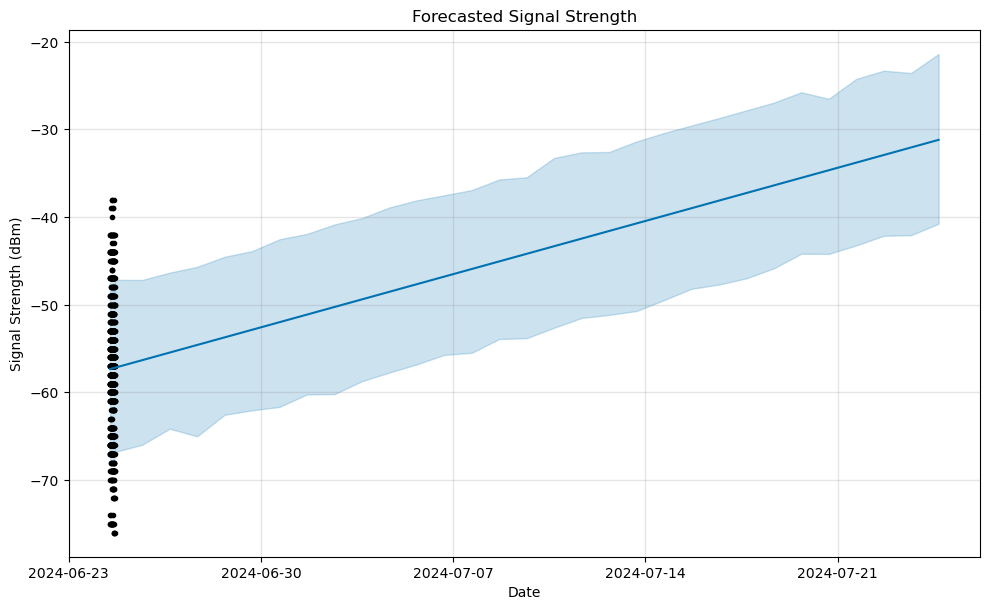

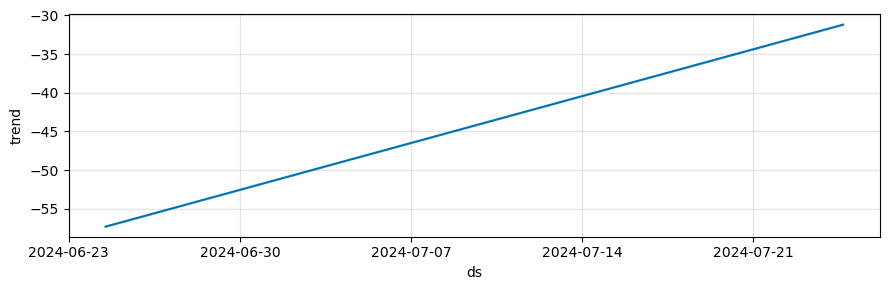

Forecast saved to 'forecasted_signal_strength.csv'.


In [32]:
telemetry_df = telemetry_df.sort_values(by='time')
telemetry_df['time'] = pd.to_datetime(telemetry_df['time']) 
signal_df = telemetry_df[['time', 'signal']].dropna()
signal_df = signal_df.rename(columns={'time': 'ds', 'signal': 'y'}) 
model = Prophet()
model.fit(signal_df)

future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)
fig = model.plot(forecast)
plt.title('Forecasted Signal Strength')
plt.xlabel('Date')
plt.ylabel('Signal Strength (dBm)')
plt.show()
fig_components = model.plot_components(forecast)
plt.show()
forecast.to_csv('forecasted_signal_strength.csv', index=False)
print("Forecast saved to 'forecasted_signal_strength.csv'.")